In [1]:
import requests
from bs4 import BeautifulSoup
import spacy
import pandas as pd 

In [2]:
estados = ["Edomex","CDMX","Jalisco", "Veracruz", "Puebla", "Guanajuato", "NuevoLeon", "Chiapas", "Michoacan", "Oaxaca", "BajaCalifornia", "BajaCaliforniaSur", "Chihuahua", "Coahuila", "Durango", "Sinaloa", "Sonora", "Tamaulipas"]

In [3]:
#get the links for each state, and stores them on the dict links_estados
links_estados = {}

for estado in estados:
    filename = "links" + estado + ".txt"

    with open(filename, "r", encoding="utf-8") as f:
        links_estados[estado] = f.readlines()
    

In [5]:
headers = {}
# Use realistic browser headers
browser_headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/123.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
}

for estado in links_estados:
    headers_estado = []
    for url in links_estados[estado]:
        url = url.strip()

        try:
            response = requests.get(url, headers = browser_headers, timeout = 300)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, "lxml")

            # Try <title> first
            title_tag = soup.find("title")
            if title_tag and title_tag.get_text(strip = True):
                title = title_tag.get_text(strip = True)
            else:
                # Fallback: Try Open Graph title
                og_title = soup.find("meta", property = "og:title")
                if og_title and og_title.get("content"):
                    title = og_title["content"].strip()
                else:
                    print(f"No title found for {url}")
                    title = "No title found"

            headers_estado.append(title)

        except requests.exceptions.HTTPError as http_err:
            print(f"HTTP error for {url}: {http_err}")
        except requests.exceptions.RequestException as req_err:
            print(f"Request failed for {url}: {req_err}")
        except Exception as e:
            print(f"Unexpected error for {url}: {e}")

    headers[estado] = headers_estado

HTTP error for https://imagendelgolfo.mx/veracruz/cruz-roja-cierra-dos-bases-en-veracruz-por-pandemia-de-covid-19/50007667: 404 Client Error: Not Found for url: https://imagendelgolfo.mx/veracruz/cruz-roja-cierra-dos-bases-en-veracruz-por-pandemia-de-covid-19/50007667
HTTP error for https://imagendelgolfo.mx/veracruz/imss-71-de-veracruz-celebra-dar-de-alta-a-tres-pacientes-con-covid-19/50011801: 404 Client Error: Not Found for url: https://imagendelgolfo.mx/veracruz/imss-71-de-veracruz-celebra-dar-de-alta-a-tres-pacientes-con-covid-19/50011801
HTTP error for https://imagendelgolfo.mx/veracruz/neumologos-exhortan-a-tomar-precauciones-tras-deteccion-de-coronavirus-en-veracruz/50002719: 404 Client Error: Not Found for url: https://imagendelgolfo.mx/veracruz/neumologos-exhortan-a-tomar-precauciones-tras-deteccion-de-coronavirus-en-veracruz/50002719
HTTP error for https://imagendelgolfo.mx/xalapa/contempla-imss-2-hospitales-de-veracruz-para-escenario-3/50005678: 404 Client Error: Not Found 

In [ ]:
#Esta parte del código fue para contar y clasificar los errores para poder resolverlos
k_errores = {}
k_errores["Error 404"] = 0
k_errores["Bad Request"] = 0
k_errores["403 Forbidden"] = 0

for head in headers:
    print(head)
    errors = 0

    c = 1

    for l in headers[head]:
        if "Error 404" in l or "Bad Request" in l or "403 Forbidden" in l:
            if "Error 404" in l:
                k_errores['Error 404'] += 1
            if "Bad Request" in l:
                k_errores['Bad Request'] += 1
            if "403 Forbidden" in l:
                k_errores['403 Forbidden'] += 1

            errors += 1
        
        print(c, l)
        c += 1

    print(head, errors, "errores")
    print("-----------------------------------------------------------------")

for i in k_errores:
    print(i, k_errores[i])

In [19]:
#creamos todos los archivos para guardar la información de los headers
#Sólo se corre una vez

file_names = []

for estado in estados:
    name = "headers" + estado + ".txt"
    file_names.append(name)
    with open(name, "w", encoding="utf-8") as f:
        for head in headers[estado]:
            f.write(head + "\n")

KeyError: 'Jalisco'

In [18]:
#después de terminar de limpiar manualmente los datos, actualizamos las variables
#Consideramos que la información está en los archivos, ya sin correr el scraping
#Volvemos a declarar el diccionario de headers, para manipular los datos más fácil
file_names.append("Jalisco")

headers = {} #El mapa headers almacena toda la información de los headers por estado

for filename in file_names:
    with open(filename, "r", encoding="utf-8") as f:
        state = filename.removeprefix("headers").removesuffix(".txt")
        headers[state] = [line.strip() for line in f if line.strip()]


FileNotFoundError: [Errno 2] No such file or directory: 'Jalisco'

In [13]:
#Función para lemmatizar y stemmizar las palabras de los headers
import spacy
from nltk.stem.snowball import SpanishStemmer

nlp = spacy.load("es_core_news_sm")
stemmer = SpanishStemmer()

def lemmatize_and_stem(text, remove_stopwords=True):
    doc = nlp(text)
    result = []

    for token in doc:
        if token.is_punct or token.is_space:
            continue

        if remove_stopwords and token.is_stop:
            continue

        lemma = token.lemma_.lower()
        stem = stemmer.stem(lemma)

        result.append(stem)

    return result


In [17]:
d = []
for i in range(0, 10):
    d.append({})
    
palabras_estado = dict(zip(estados, d)) #Diccionario para almacenar la recuencia de cada palabra por estado

nlp = spacy.load("es_core_news_sm")
file_names.append("Jalisco")
for estado in estados:
    for header in headers[estado]:
        lmm_hedaer = lemmatize_and_stem(header.lower())

        for l in lmm_hedaer:
            if l.isdigit():
                continue  # Evitar los dígitos, ya que no son palabras
            
            if l not in palabras_estado[estado]:
                palabras_estado[estado][l] = 1
            else:
                palabras_estado[estado][l] += 1

    #Se ordenan las palabras más frecuentes por estado
    palabras_estado[estado] = dict(sorted(palabras_estado[estado].items(), key=lambda x: x[1], reverse=True))  


KeyError: 'Jalisco'

In [14]:
#creamos todos los archivos para guardar la información de los headers
#Sólo se corre una vez
for estado in palabras_estado:
    name = "palabras" + estado + ".txt"
    with open(name, "w", encoding="utf-8") as f:
        for palabra in palabras_estado[estado]:
            f.write(palabra + "," + str(palabras_estado[estado][palabra]) + '\n')

In [15]:
#Para análisis globales, un diccionario de frecuencias de todas las palabras
all_words = dict()
for estado in headers:
    for k in palabras_estado[estado]:
        if k not in all_words:
            all_words[k] = 0
        
        all_words[k] += palabras_estado[estado][k]


#ordenar las palabras más frecuentes
all_words_sorted = dict(sorted(all_words.items(), key=lambda x: x[1], reverse=True))  # By value, descending

for l in all_words_sorted:
    print(l, all_words_sorted[l])


covid-19 373
coronavirus 235
cas 115
mexic 82
hospital 80
pandemi 79
cerr 78
puebl 57
contingent 54
salud 51
med 49
san 43
suspend 40
contagi 37
cdmx 34
cuarenten 33
medic 31
imss 31
veracruz 29
atend 28
sanitari 28
leon 28
map 27
cov 25
ped 24
sant 24
pacient 24
merc 23
oaxac 23
trabaj 22
emergent 22
activ 21
personal 21
pes 21
covid19 21
abril 20
public 20
fas 19
chiap 19
michoacan 19
municipi 18
centr 18
guadalaj 18
call 17
transport 17
oms 17
pobl 17
edomex 16
servici 16
apoy 16
penal 15
posit 15
aplic 15
ofrec 15
distanci 15
mil 14
priv 14
viv 14
enfrent 14
general 14
prevent 14
virus 14
covid–19 14
moreli 14
person 13
confirm 13
visit 13
prevencion 13
atencion 13
cubreboc 13
agu 13
line 12
evit 12
restring 12
pas 12
polic 12
seman 12
fallec 12
cancel 12
cruz 12
jalisc 12
toluc 11
vall 11
falt 11
tianguis 11
mexican 11
emple 11
registr 11
luc 11
econom 11
mor 11
indigen 11
equip 11
año 11
instal 11
clas 11
marz 10
aument 10
negoci 10
sum 10
entreg 10
deten 10
famili 10
clinic 10
p

In [4]:
#Datos de COVID en cada estado, del 15 de marzo al 30 de abril de 2020
cases_map = {
    "CDMX": 13366,
    "Chiapas": 404,
    "Edomex": 9246,
    "Guanajuato": 502,
    "Jalisco": 587,
    "Michoacan": 603,
    "NuevoLeon": 582,
    "Oaxaca": 355,
    "Puebla": 1228,
    "Veracruz": 1562
}

poblacion_mexico_2020 = {
    "Chiapas": 5543828,
    "Guanajuato": 6166934,
    "Jalisco": 8348151,
    "CDMX": 9209944,
    "Edomex": 16992418,
    "Michoacan": 4748846,
    "NuevoLeon": 5784442,
    "Oaxaca": 4132148,
    "Puebla": 6583278,
    "Veracruz": 8062579
}

percentage_infected = {}

for estado in estados:
    percentage_infected[estado] = cases_map[estado] * 100 / poblacion_mexico_2020[estado]



In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords

spanish_stopwords = stopwords.words('spanish')

# 1. Prepare state-wise documents
documents = [" ".join(headers[estado]) for estado in estados]

print(documents)

['Edomex, entre los estados con más perdida de empleos por Covid-19 Ajustará Edomex su presupuesto para atender crisis por Covid-19 Aumentan a 2 mil 355 los casos positivos a Covid-19 en el Edomex Edomex registra 10 casos de COVID-19 Aumentan a mil 992 los casos positivos de Covid-19 en el Edomex Burlan municipios mexiquenses protocolo contra Covid-19 y Viernes Santo Habilitan línea telefónica para recibir quejas del personas de Salud en el Edomex Correos de México no lo detiene el COVID-19 Suspenden visitas familiares en el penal de Cuautitlán por casos sospechosos de Covid-19 Suspenden actividades tianguis del Edomex por COVID-19 Personal del SUEM, capacitados para el traslado de pacientes con COVID-19 Sin confirmar 19 posibles casos de Covid-19 de reos mexiquenses Xonacatlán confirma primer caso positivo de COVID-19 Sostienen gobernadores y gabinete federal videoconferencia por COVID-19 Cierran presidencia de Los Reyes La Paz por positivo a Covid-19 Sin cambios los tianguis en puebl

In [17]:
# 2. TF-IDF with Spanish stopwords, filtering out words that appear in <2 states
#Se aplica la técnica TF-IDF (Term Frequency - Inverse Document Frequency) 
#para filtrar stopwords, al ponderar palabras según su frecuencia en los headers
#Elimina las que son poco relevantes
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words=spanish_stopwords,
    min_df = 5  # must appear in at least 2 documents (states)
)


tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

# 3. Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=estados, columns=feature_names)

# 4. Add COVID case target
tfidf_df["covid_cases"] = tfidf_df.index.map(percentage_infected)

tfidf_df


,10,19,25,30,abasto,acceso,actividad,actividades,agua,apoyo,...,tres,universidades,van,ventas,vida,violencia,virus,vive,zona,covid_cases
Edomex,0.013963,0.596228,0.015446,0.015446,0.030891,0.012679,0.013963,0.023093,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.013963,0.000000,0.000000,0.000000,0.054413
CDMX,0.029430,0.618206,0.016277,0.000000,0.032555,0.013362,0.014715,0.000000,0.000000,0.016277,...,0.029430,0.000000,0.016277,0.016277,0.000000,0.000000,0.048832,0.016277,0.032555,0.145126
Jalisco,0.000000,0.607172,0.000000,0.000000,0.000000,0.013802,0.015200,0.000000,0.000000,0.033628,...,0.030400,0.000000,0.016814,0.016814,0.000000,0.015200,0.084069,0.000000,0.016814,0.007031
Veracruz,0.000000,0.557251,0.000000,0.000000,0.000000,0.022960,0.025285,0.062726,0.000000,0.083908,...,0.050570,0.000000,0.000000,0.027969,0.000000,0.025285,0.000000,0.000000,0.055939,0.019373
Puebla,0.015839,0.545439,0.000000,0.017521,0.000000,0.000000,0.000000,0.013098,0.105126,0.017521,...,0.015839,0.017521,0.000000,0.000000,0.017521,0.000000,0.000000,0.000000,0.000000,0.018653
Guanajuato,0.030323,0.584740,0.033542,0.000000,0.000000,0.000000,0.030323,0.075223,0.000000,0.000000,...,0.030323,0.033542,0.067084,0.000000,0.067084,0.000000,0.000000,0.000000,0.000000,0.008140
NuevoLeon,0.023068,0.333632,0.051034,0.051034,0.025517,0.020947,0.000000,0.019075,0.051034,0.025517,...,0.000000,0.000000,0.025517,0.000000,0.025517,0.023068,0.076551,0.025517,0.000000,0.010061
Chiapas,0.030353,0.522604,0.000000,0.033575,0.000000,0.027561,0.000000,0.025099,0.100725,0.000000,...,0.091058,0.033575,0.000000,0.033575,0.033575,0.060705,0.000000,0.033575,0.033575,0.007287
Michoacan,0.000000,0.613958,0.000000,0.070436,0.035218,0.000000,0.031838,0.052654,0.035218,0.000000,...,0.000000,0.035218,0.000000,0.000000,0.000000,0.000000,0.070436,0.105654,0.000000,0.012698
Oaxaca,0.000000,0.584636,0.044715,0.000000,0.022357,0.018353,0.000000,0.016713,0.067072,0.000000,...,0.000000,0.022357,0.022357,0.022357,0.044715,0.020211,0.022357,0.022357,0.022357,0.008591


In [ ]:
#Imprimimos las palabras más relevantes
importances = reg.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances

top_words = [feature_names[i] for i in indices[:100]]  # Top 5 words
top_importances = importances[indices[:100]]

print("Top 100 de palabras relevantes:")
for word, importance in zip(top_words, top_importances):
    print(f"{word}")

In [23]:
#Intentamos buscar correlación usando un árbol regresor, es similar a un árbol de decisoón, pero
#hace predicciones con valores numéricos continuos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


X = tfidf_df.drop(columns=["covid_cases"]) #todas las columnas excepto la de casos
y = tfidf_df["covid_cases"] #la columna de casos

reg = DecisionTreeRegressor(random_state = 54)
reg.fit(X, y)

#Evaluación con cross validator
scores = cross_val_score(reg, X, y, cv = 5, scoring='r2')
print("Cross-validated R^2:", scores.mean())

#Podemos observar que el modelo no es preciso en absoluto. Se debe a varios factores, lo más probable es que se usan demasiadas
#palabras en el modelo


Cross-validated R^2: -1436.691352969723


### Clasificación de palabras por valor de sentimiento ###

In [24]:

from transformers import pipeline

# Usamos el sentiment analysis pipeline del modelo BETO 
#El modelo califica las palabras en una escala del 1-5, donde 1 es muy negativa y 5 es muy positiva
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

d = {i: 0 for i in range(1, 6)}

scores = {}
for estado in estados:
    scores[estado] = d.copy()

total_score_state = {}

for estado in estados:
    total_score = 0
    scored_headers = {}

    results = classifier(headers[estado])
    
    for result in results:
        label = result["label"]
        score = int(label[0])
        scores[estado][score] += 1

        total_score += int(score)
        #print(i)
    
    total_score_state[estado] = total_score

    print(estado, "- score:", total_score) #Imprimimos el valor de "sentimiento" total de los estados
    #Mienrtras sea mayor, dado que se considera aproximadamente la misma cantidad de palabras en cada estado, 
    #significa que las palbras fueron más laxas


Device set to use cpu


Edomex - score: 288
CDMX - score: 343
Jalisco - score: 303
Veracruz - score: 225
Puebla - score: 279
Guanajuato - score: 316
NuevoLeon - score: 333
Chiapas - score: 309
Michoacan - score: 270
Oaxaca - score: 285


In [25]:
# Creamos un dataframe con la cantidad de palabras con cada clasificación
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores = df_scores[[1, 2, 3, 4, 5]]

df_scores["Casos COVID"] = df_scores.index.map(cases_map)
df_scores['Poblacion_total'] = df_scores.index.map(poblacion_mexico_2020)
df_scores['Porcentaje_contagiado'] = df_scores['Casos COVID'] * 100/df_scores['Poblacion_total']

df_scores

,1,2,3,4,5,Casos COVID,Poblacion_total,Porcentaje_contagiado
Edomex,64,1,7,24,21,9246,16992418,0.054413
CDMX,53,6,4,19,38,13366,9209944,0.145126
Jalisco,56,5,8,22,25,587,8348151,0.007031
Veracruz,50,2,3,23,14,1562,8062579,0.019373
Puebla,70,4,3,18,24,1228,6583278,0.018653
Guanajuato,47,6,3,27,28,502,6166934,0.008140
NuevoLeon,53,3,5,26,31,582,5784442,0.010061
Chiapas,53,7,8,17,30,404,5543828,0.007287
Michoacan,37,6,6,17,27,603,4748846,0.012698
Oaxaca,62,3,4,25,21,355,4132148,0.008591


In [27]:
# Análisis similar al anterior, pero con headers comletos en vez de 
import spacy
from nltk.stem.snowball import SpanishStemmer
from collections import defaultdict
from transformers import pipeline

nlp = spacy.load("es_core_news_sm")
stemmer = SpanishStemmer()
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def lemmatize_and_stem(text, remove_stopwords=True):
    doc = nlp(text)
    result = []

    for token in doc:
        if token.is_punct or token.is_space:
            continue
        if remove_stopwords and token.is_stop:
            continue

        lemma = token.lemma_.lower()
        stem = stemmer.stem(lemma)
        result.append(stem)

    return result

def score_header(stemmed_tokens):
    text = " ".join(stemmed_tokens)  # Join tokens back into string
    score = classifier(text)[0]['label']  # e.g. '1 star'
    # Extract numeric part only
    return int(score[0])

# Ensure headers is a dictionary
score_headers = defaultdict(lambda: defaultdict(int))  # score_headers[state][score] = count

for state in headers:
    for header in headers[state]:
        stemmed_header = lemmatize_and_stem(header)
        score = score_header(stemmed_header)
        score_headers[state][score] += 1

# Display
for state in score_headers:
    print(state)
    print(score_headers[state])


Device set to use cpu


Edomex
defaultdict(<class 'int'>, {1: 64, 4: 19, 5: 16, 3: 17, 2: 1})
CDMX
defaultdict(<class 'int'>, {1: 56, 4: 15, 5: 30, 3: 19})
Jalisco
defaultdict(<class 'int'>, {1: 47, 5: 29, 2: 2, 3: 22, 4: 16})
Veracruz
defaultdict(<class 'int'>, {1: 38, 5: 21, 3: 19, 2: 1, 4: 13})
Puebla
defaultdict(<class 'int'>, {1: 62, 5: 25, 3: 20, 4: 9, 2: 3})
Guanajuato
defaultdict(<class 'int'>, {1: 45, 5: 37, 3: 20, 4: 9})
NuevoLeon
defaultdict(<class 'int'>, {3: 16, 1: 56, 5: 33, 4: 13})
Chiapas
defaultdict(<class 'int'>, {5: 32, 4: 9, 3: 21, 1: 53})
Michoacan
defaultdict(<class 'int'>, {5: 26, 1: 40, 3: 15, 2: 2, 4: 10})
Oaxaca
defaultdict(<class 'int'>, {1: 55, 4: 17, 5: 24, 2: 2, 3: 17})


In [28]:
all_states = sorted(score_headers.keys())
all_scores = [1, 2, 3, 4, 5]

data = []
for state in all_states:
    row = []
    for score in all_scores:
        row.append(score_headers[state].get(score, 0))
    data.append(row)

df_scores_headers = pd.DataFrame(data, columns=[s for s in all_scores], index=all_states)
df_scores_headers['Porcentaje de contagios'] = df_scores['Porcentaje_contagiado'] 

df_scores_headers

,1,2,3,4,5,Porcentaje de contagios
CDMX,56,0,19,15,30,0.145126
Chiapas,53,0,21,9,32,0.007287
Edomex,64,1,17,19,16,0.054413
Guanajuato,45,0,20,9,37,0.008140
Jalisco,47,2,22,16,29,0.007031
Michoacan,40,2,15,10,26,0.012698
NuevoLeon,56,0,16,13,33,0.010061
Oaxaca,55,2,17,17,24,0.008591
Puebla,62,3,20,9,25,0.018653
Veracruz,38,1,19,13,21,0.019373


### Gráficas ###

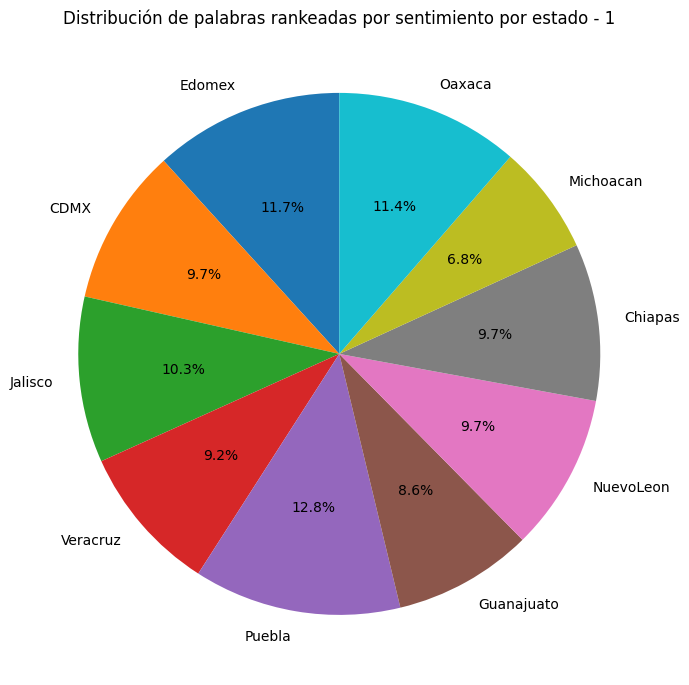

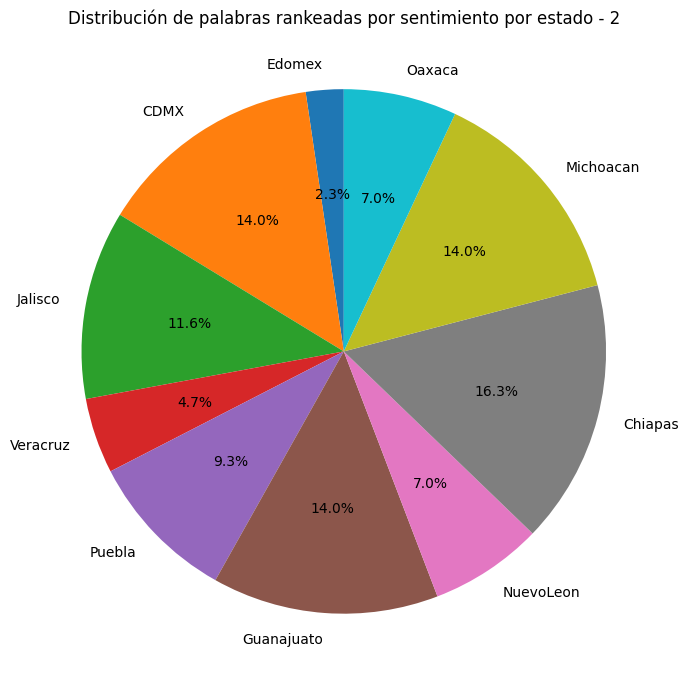

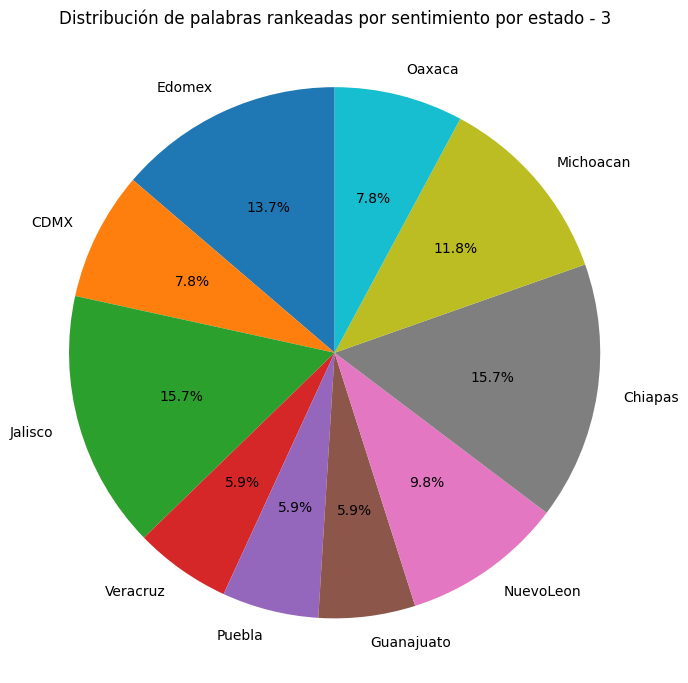

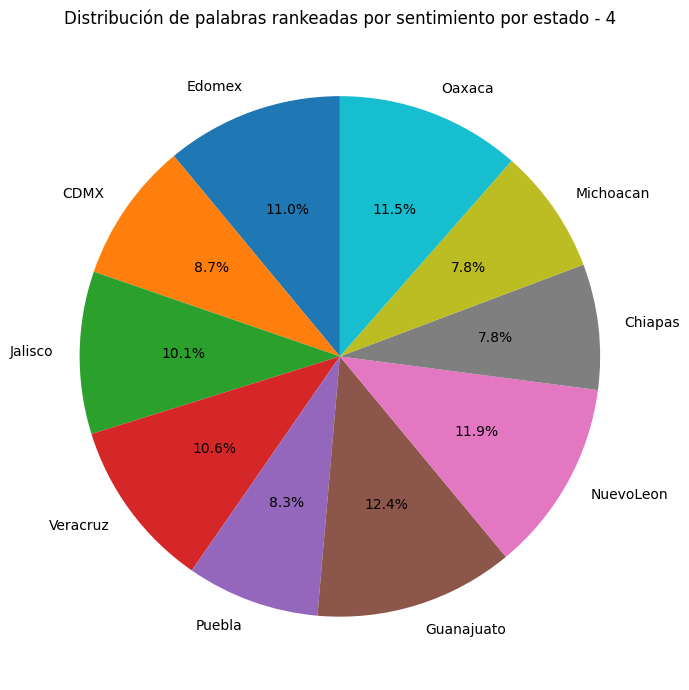

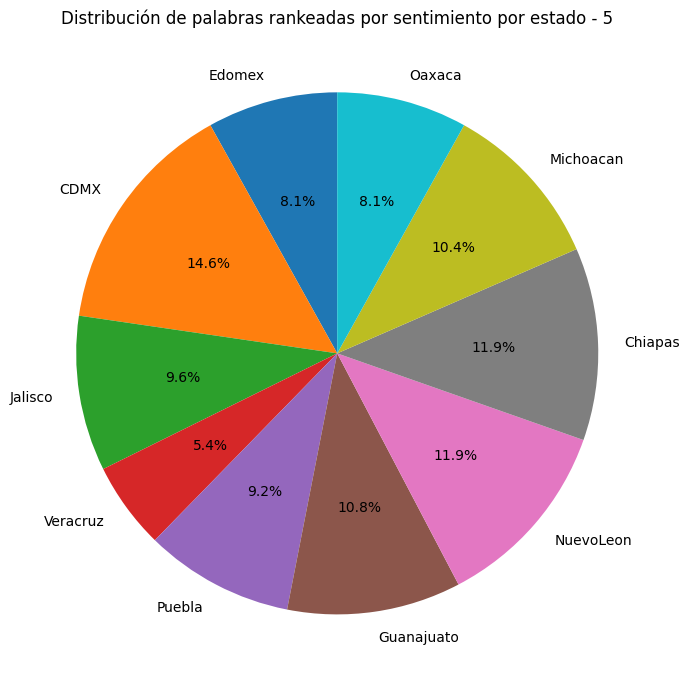

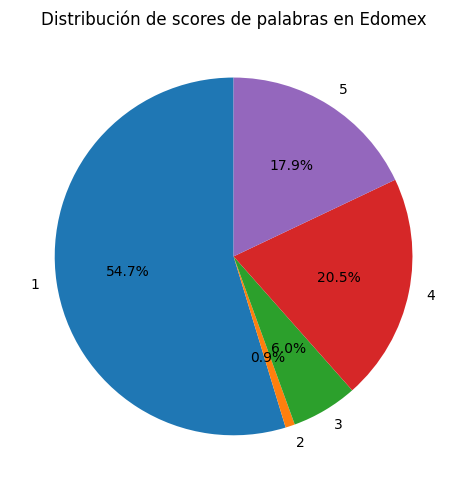

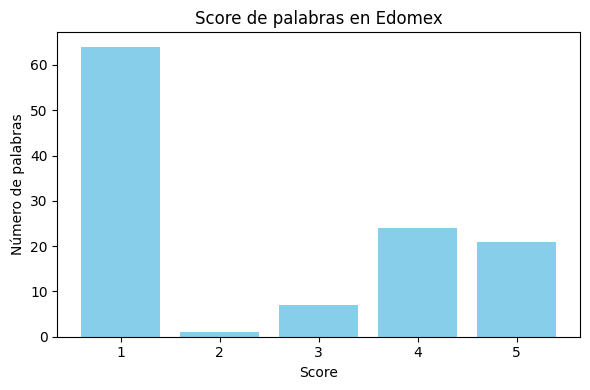

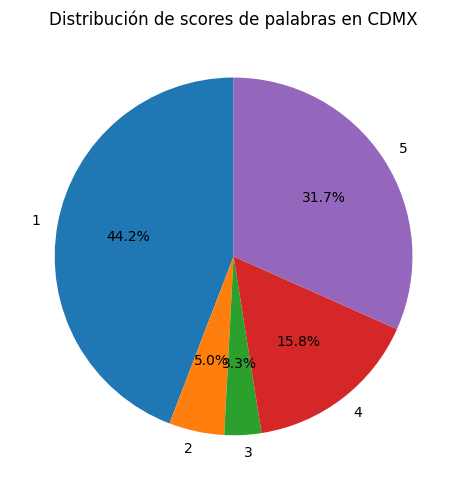

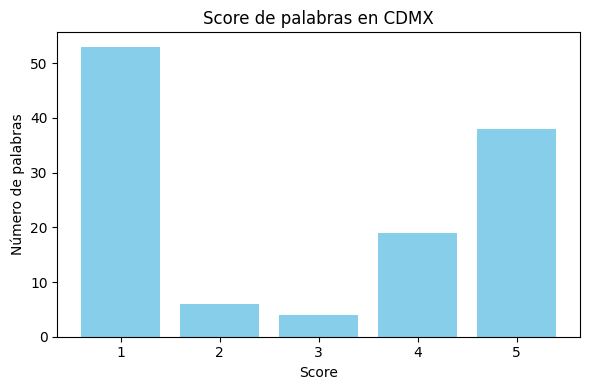

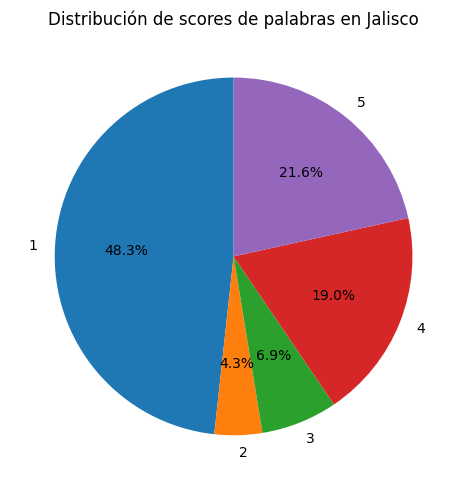

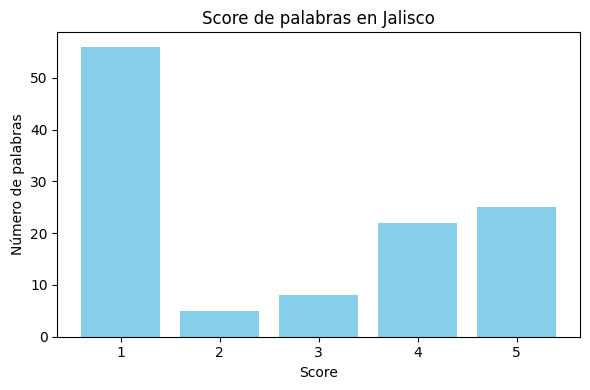

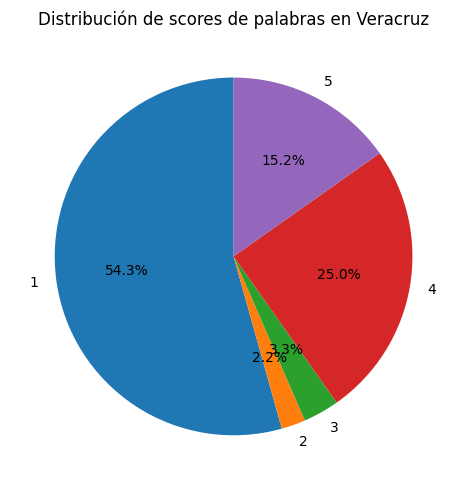

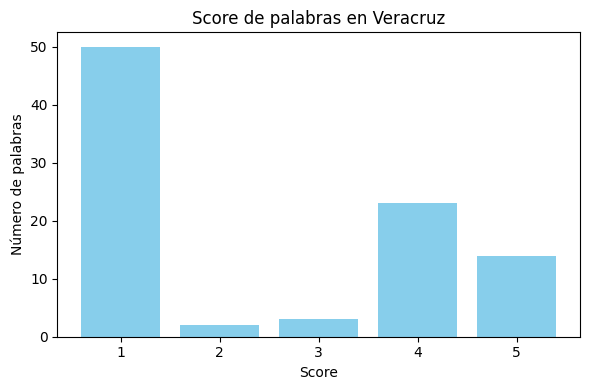

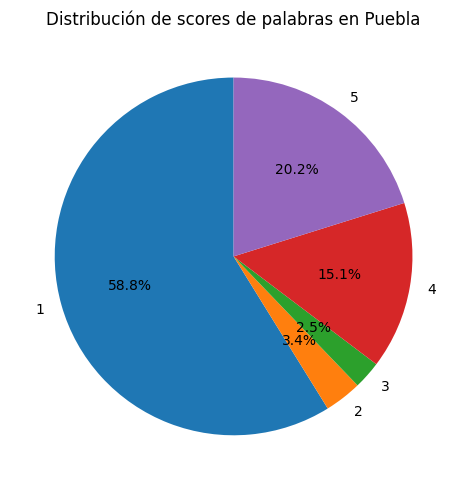

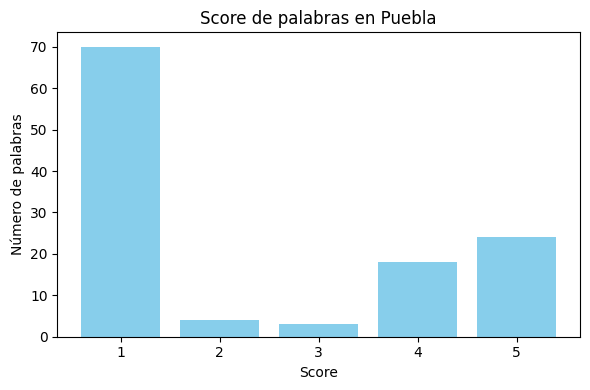

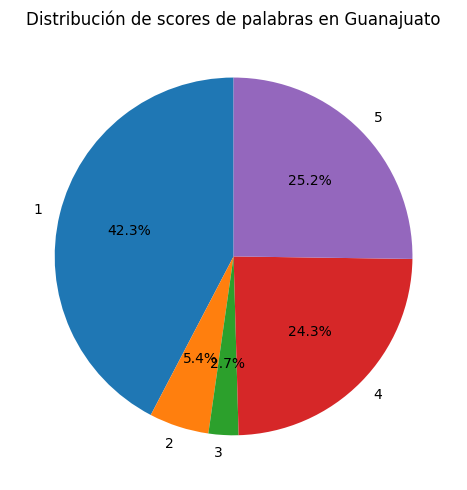

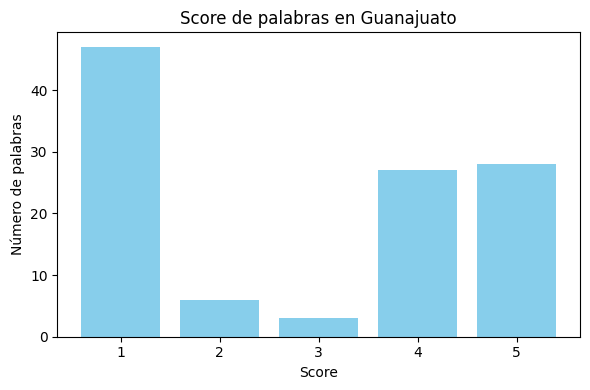

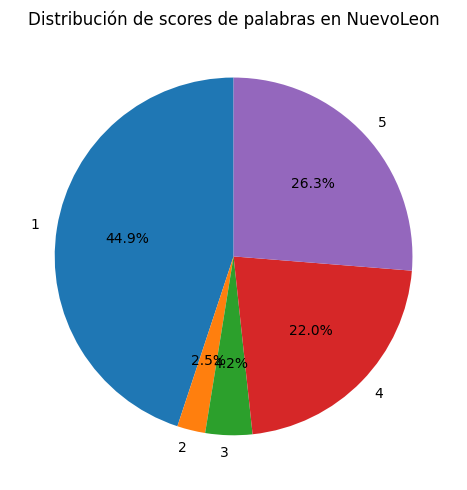

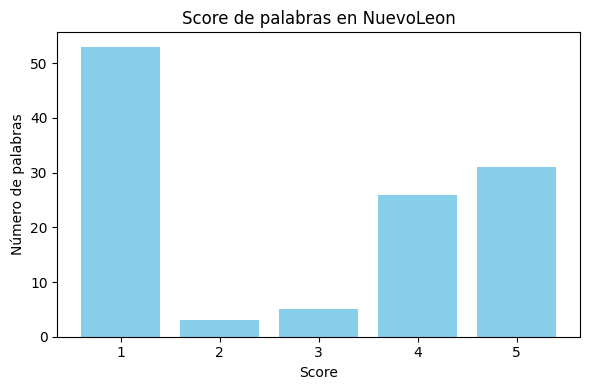

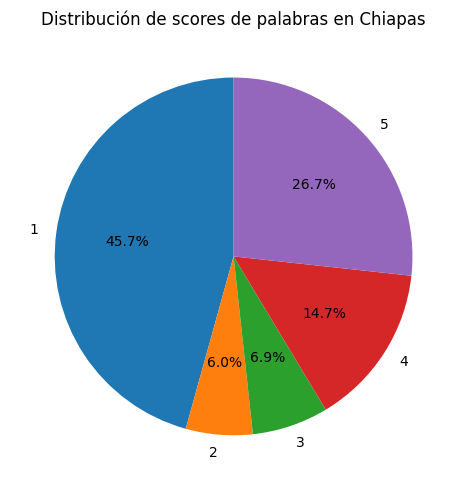

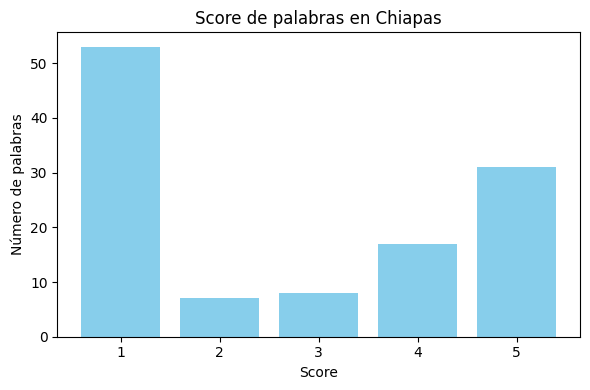

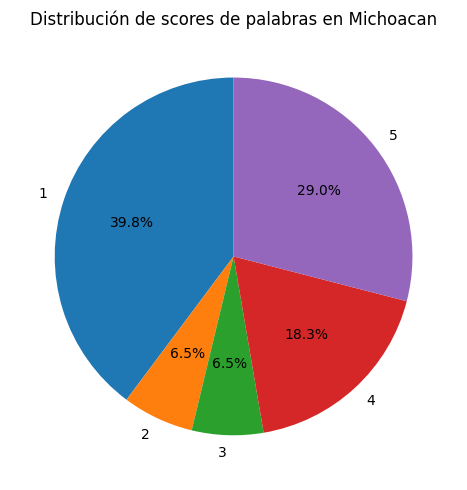

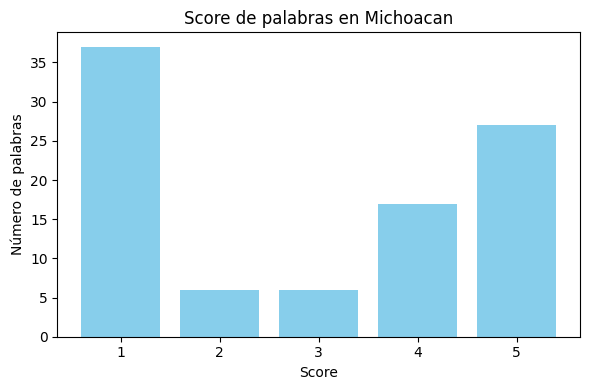

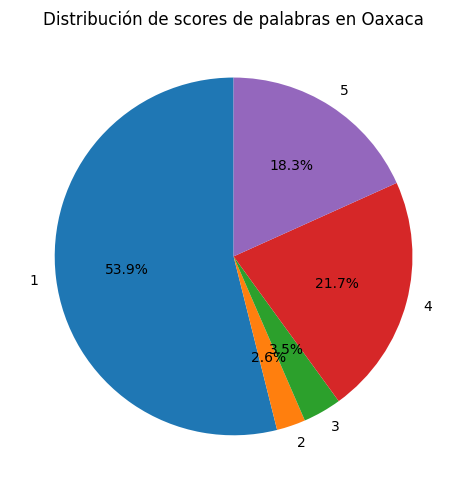

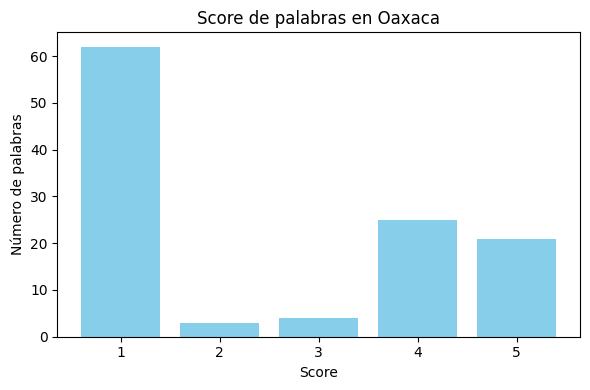

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

for score in df_scores.columns[:5]:
    sales = df_scores[score]
    plt.figure(figsize=(7, 7))
    plt.pie(sales, labels = df_scores.index, autopct="%1.1f%%", startangle=90)
    plt.title(f"Distribución de palabras rankeadas por sentimiento por estado - {score}")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

df_graph = df_scores.iloc[:, :5]

# Loop through each state to create plots
for state in df_graph.index:
    state_scores = df_graph.loc[state]

    plt.figure(figsize=(5, 5))
    plt.pie(state_scores, labels = df_graph.columns, autopct='%1.1f%%', startangle=90)
    plt.title(f"Distribución de scores de palabras en {state}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.bar(df_graph.columns, state_scores, color='skyblue')
    plt.title(f"Score de palabras en {state}")
    plt.xlabel("Score")
    plt.ylabel("Número de palabras")
    plt.tight_layout()
    plt.show()



In [29]:
df_scores_sorted = df_scores.sort_values(by = "Porcentaje_contagiado", ascending=False)
df_scores_sorted


,1,2,3,4,5,Casos COVID,Poblacion_total,Porcentaje_contagiado
CDMX,53,6,4,19,38,13366,9209944,0.145126
Edomex,64,1,7,24,21,9246,16992418,0.054413
Veracruz,50,2,3,23,14,1562,8062579,0.019373
Puebla,70,4,3,18,24,1228,6583278,0.018653
Michoacan,37,6,6,17,27,603,4748846,0.012698
NuevoLeon,53,3,5,26,31,582,5784442,0.010061
Oaxaca,62,3,4,25,21,355,4132148,0.008591
Guanajuato,47,6,3,27,28,502,6166934,0.008140
Chiapas,53,7,8,17,30,404,5543828,0.007287
Jalisco,56,5,8,22,25,587,8348151,0.007031


In [43]:
import pandas as pd

data = {}
for state in palabras_estado:
    state_data = {}
    for word in top_words:
        state_data[word] = palabras_estado[state].get(word, 0)  # get frequency or 0 if missing
    data[state] = state_data

word_freq_df = pd.DataFrame.from_dict(data, orient='index')
word_freq_df["covid_cases"] = pd.Series(percentage_infected)
correlation_matrix = word_freq_df.corr()
word_correlations = correlation_matrix["covid_cases"].drop("covid_cases")
top_correlated_words = word_correlations.abs().sort_values(ascending=False)

print("Palabras más relacionadas con el porcentaje de casos COVID:")
print(top_correlated_words.head(10))



Palabras más relacionadas con el porcentaje de casos COVID:
cdmx        0.827681
hospital    0.526481
general     0.521344
crisis      0.306459
mil         0.248914
tianguis    0.239851
salud       0.212318
virus       0.183760
san         0.170471
federal     0.162313
Name: covid_cases, dtype: float64


### Modelos de predicción ###

##### Regresión lineal, pero dado que el tamaño de la muestra es pequeño, da una correlación poco verídica #####

R² score: 0.8811043545734928
RMSE: 0.00851669975674077


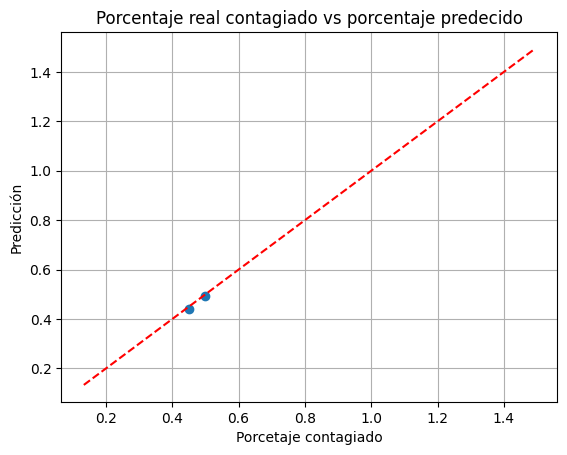

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt

X = df_scores[[5, 2]]
y = df_scores['Porcentaje_contagiado']

# División de la muestra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 54)

model = LinearRegression()
model.fit(X_train, y_train)

# 5. Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("R² score:", r2)
print("RMSE:", rmse)

# 7. (Optional) Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Porcetaje contagiado")
plt.ylabel("Predicción")
plt.title("Porcentaje real contagiado vs porcentaje predecido")
plt.grid()
plt.show()

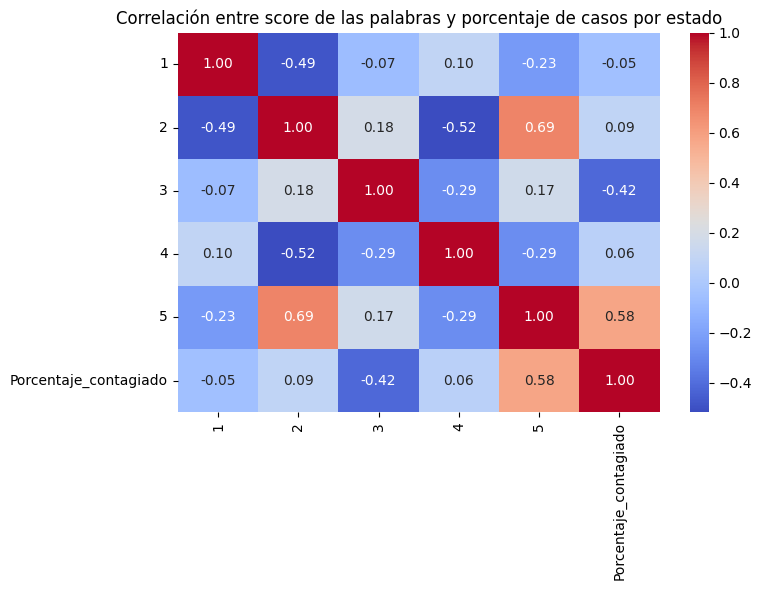

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
corr_df = df_scores[[1, 2, 3, 4, 5, 'Porcentaje_contagiado']]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Display correlation matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre score de las palabras y porcentaje de casos por estado")
plt.tight_layout()
plt.show()
#hay correlacion entre porcentaje y palabras con score 5

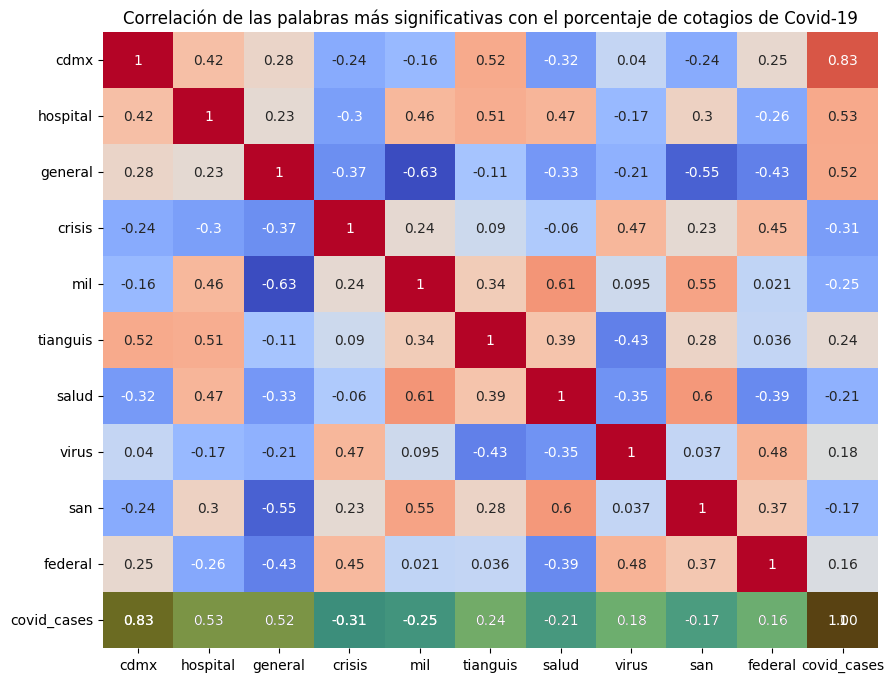

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example heatmap data (you can use your correlation matrix directly)
corr_matrix = word_freq_df[top_correlated_words.head(10).index.tolist() + ["covid_cases"]].corr()

# Create a mask for the whole matrix (False = show, True = hide)
mask = np.zeros_like(corr_matrix, dtype=bool)

# Create a mask where only the last row is False (shown)
mask[:-1, :] = True  # only keep the last row visible

# Plot the heatmap normally
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", cbar=False)

# Overlay the last row in green
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=sns.color_palette(["green"]),
    cbar=False,
    annot_kws={"color": "white"},  # adjust annotation color if needed
    alpha=0.5
)

plt.title("Correlación de las palabras más significativas con el porcentaje de cotagios de Covid-19")
plt.show()


Equation: y ≈ 0.05×Score5 + -0.11×Score6 + -0.36


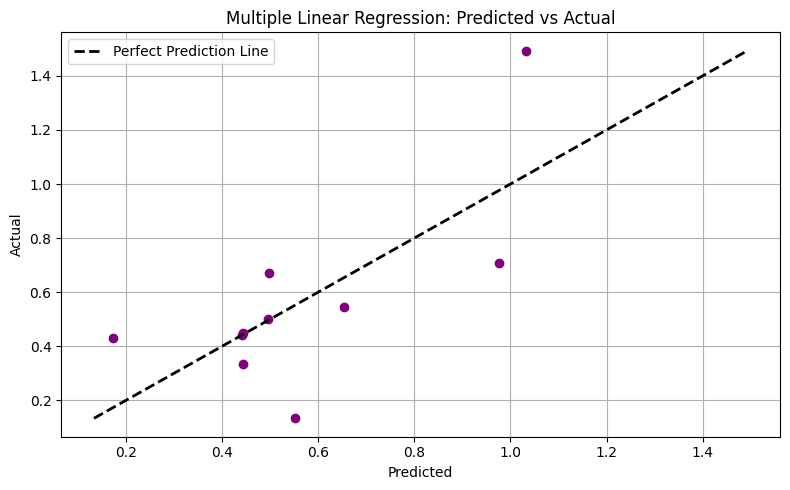

R² score: 0.510
RMSE: 0.241


In [ ]:
#dado que 5 se relaciona con porcentaje y 2 co 5, usamos esos dos
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

X_multi = df_scores[[5, 2]] 
y_porcentaje = df_scores['Porcentaje_contagiado']

multi_model = LinearRegression()
multi_model.fit(X_multi, y_porcentaje)

y_pred = multi_model.predict(X_multi)

coefs = multi_model.coef_
intercept = multi_model.intercept_
print(f"Equation: y ≈ {coefs[0]:.2f}×Score5 + {coefs[1]:.2f}×Score6 + {intercept:.2f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_porcentaje, color="purple")
plt.plot([y_porcentaje.min(), y_porcentaje.max()],
         [y_porcentaje.min(), y_porcentaje.max()],
         'k--', lw=2, label="Perfect Prediction Line")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Multiple Linear Regression: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

r2 = r2_score(y_porcentaje, y_pred)
rmse = root_mean_squared_error(y_porcentaje, y_pred)

print(f"R² score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


##### Obtuvimos un modelo con precisión suficientemente alta para considerar que hay correlación entre la cantidad de palabras positivas y el porcentaje de casos COVID #####